In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Description

**The provided Python script employs machine learning techniques to predict the survival outcomes of Titanic passengers based on features such as gender, age, class, and family size. After loading and exploring the dataset, the code handles missing values, creates new features, and converts categorical variables. Visualizations offer insights into survival rates, age distribution, and feature correlations. The script then selects relevant features, splits the data into training and validation sets, and builds a RandomForestClassifier model. Following training, the model predicts survival on the test dataset, and the results are saved to a CSV file for submission. The script provides a comprehensive approach to data preprocessing, feature engineering, model training, and result generation for the Titanic survival prediction task.**

## Importing Libraries:

**NumPy and Pandas are imported for data manipulation.
Matplotlib and Seaborn are imported for data visualization.
os is imported to work with file paths.**

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data:

**The script reads the training and testing datasets from the Titanic dataset using Pandas.**


In [7]:
training = pd.read_csv("/kaggle/input/titanic/train.csv")
training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
testing = pd.read_csv("/kaggle/input/titanic/test.csv")
testing.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Exploratory Data Analysis (EDA):

1.  The script calculates the survival rate for men and women separately.
1.  It prints the number of missing values in each column of the training dataset.
1.  Missing values in the 'Age' column are filled with the median value.
1.  A new feature 'FamilySize' is created by combining 'SibSp' and 'Parch'.
1.  The 'Sex' column is converted to numeric values (0 for male, 1 for female).
1.  Bar chart and histogram visualizations are created for survival based on gender and age distribution, respectively.
1.  A correlation heatmap is created to visualize the correlation between numeric features

In [9]:
women = training.loc[training.Sex == 'female']["Survived"]
rate = sum(women)/len(women)

print("% of women who survived:", rate)

% of women who survived: 0.7420382165605095


In [10]:
men = training.loc[training.Sex == 'male']["Survived"]
rate= sum(men)/len(men)

print("% of men who survived:", rate)

% of men who survived: 0.18890814558058924


In [11]:
print(training.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [12]:
# Filling missing values in 'Age' with the median
training['Age'].fillna(training['Age'].median(), inplace=True)
testing['Age'].fillna(testing['Age'].median(), inplace=True)

In [13]:
# Creating a new feature 'FamilySize' by combining 'SibSp' and 'Parch'
training['FamilySize'] = training['SibSp'] + training['Parch'] + 1
testing['FamilySize'] = testing['SibSp'] + testing['Parch'] + 1

In [14]:
# Converting 'Sex' to numeric values (0 for male, 1 for female)
training['Sex'] = training['Sex'].map({'male': 0, 'female': 1})
testing['Sex'] = testing['Sex'].map({'male': 0, 'female': 1})

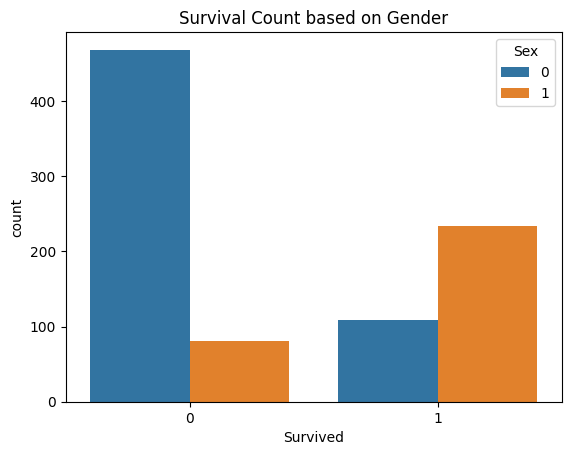

In [15]:

#Bar chart of survival based on gender
sns.countplot(x='Survived', hue='Sex', data=training)
plt.title('Survival Count based on Gender')
plt.show()

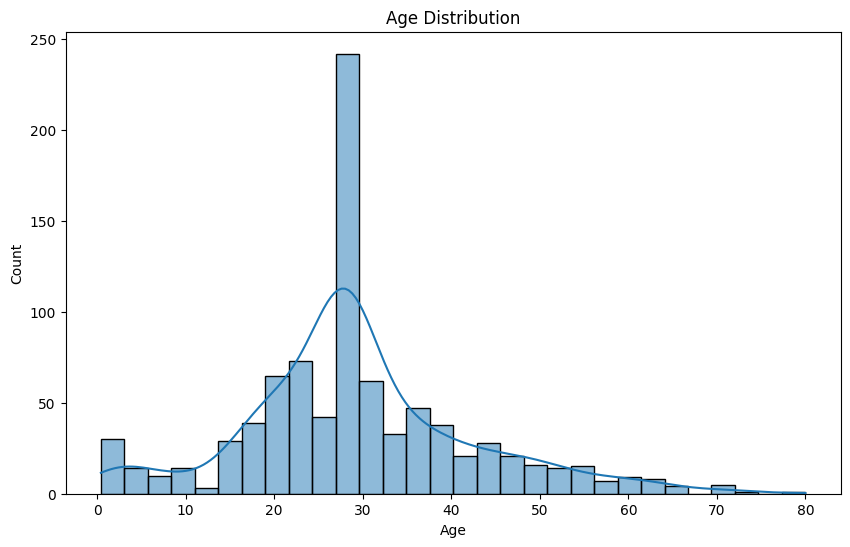

In [16]:
# Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(training['Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.show()

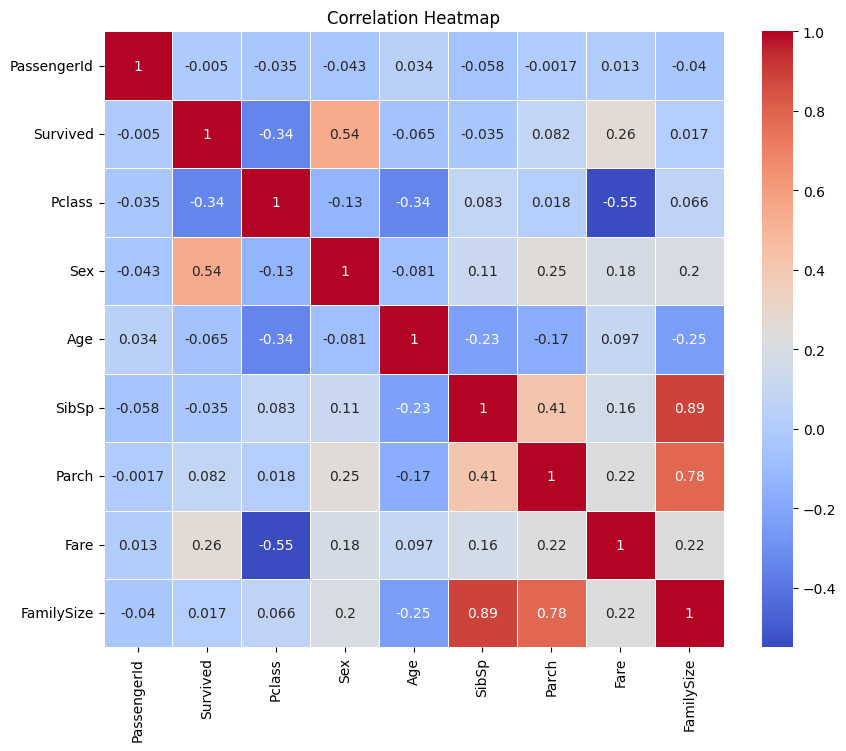

In [18]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
numeric_columns = training.select_dtypes(include=[np.number]).columns
correlation_matrix = training[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


## Feature Selection and Preprocessing:

1. Features like "Pclass," "Sex," "Age," and "FamilySize" are selected.
2. The dataset is split into features (X) and the target variable (y).
3. The data is split into training and validation sets.

In [19]:
# Selecting features and target variable
features = ["Pclass", "Sex", "Age", "FamilySize"]
X = training[features]
y = training["Survived"]


In [20]:
# Spliting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)


## Model Building:

1. A RandomForestClassifier model is created with specified parameters (n_estimators, max_depth, random_state).
2. The model is trained on the training data.

In [21]:
# Creating a RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)

In [22]:

# Fitting the model on the training data
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1)

## Making Predictions:

**The trained model is used to make predictions on the test dataset.**

In [23]:
# Making predictions on the test dataset
X_test = testing[features]
predictions = model.predict(X_test)

## Creating Output:

1. The predictions are stored in a DataFrame along with the corresponding 'PassengerId'.
2. The DataFrame is saved to a CSV file named 'submission.csv.'

In [24]:
# Creating the output DataFrame
output = pd.DataFrame({'PassengerId': testing['PassengerId'], 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
